2021.11.26 ~ 2022.02.28 => 주어진 데이터,
2022.03.04 ~ 13 그리고 03.18 ~ 20  => 검증 데이터

*최종 제출 방식))))))예보 데이터 시간 데이터 이용 => sum으로 일자 제출
분별 대체로 볼 때 0.2에서 0.4라고 한다면, 0.2 * 1440에서 0.4 * 1440 =>대략 300~500?

우선! 바운더리에 들어오면, 에너지 절감 타당한 모델을 만드는 게 핵심. 노가다 ㄴㄴ

*외부 데이터 방식)))))))관련 예보 데이터에 나와 있는 관측소만 이용해서 평균으로 보내서 하면 근거가 충분할 듯함
(주어진 게 그 관측소뿐이므로)

*주어진 데이터 방식))))열 공급량은 분=>시간 단위로 바뀔 때 합산해야함 (논리적으로 봤을 때, 시간 단위라면 분 단위의 누적이 되어야 맞는 거임. 의미적으로나 수치적으로나 둘 다.)
나머지 변수 => 일단 평균으로 (의미상,수치상 합산은 아닌듯..기온같은 경우..)

*공통))))outlier채우기, 중간에 없는 일자 뽑아서 외부,본 데이터 둘 다 삭제, 검증 데이터 3/15 삭제

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

# 데이터 로드

In [5]:
curr_dir = os.getcwd()
curr_dir

forders_tr = os.listdir(curr_dir+"\\data")
forders_tr

df = pd.read_csv(os.path.join(curr_dir+"\\data\\")+forders_tr[0])
df = df.drop(df.columns[0], axis=1)
df

df2022 = df[df['smart_farm.yy']==2022]
df2022
df202203 = df2022[df2022['smart_farm.mm']==3]
df202203

train = df.iloc[:132480]
train = train.reset_index()
train = train.drop('index', axis=1)

test = df.iloc[132480:]
test = test[test['smart_farm.dd']!=15]        # 15일자 제외
test = test.reset_index()
test = test.drop('index', axis=1)
test

# train1 = train.dropna(axis=0)
train1 = train.interpolate(method ='linear')     
# train 결측치 채운 이유=> 시간 별 데이터 중간중간 결측돼서 이를 이용해서 일자 예측하려면 채워줘야하기 때문.
test1 = test.interpolate(method ='linear') 

submission = pd.read_csv('2-1_검증데이터셋.csv')
submission1 = submission.copy()
submission1             # "년도 월 일 시 분 => 년도 월 일"  예측

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [19]:
train1[train1.columns[-1]].value_counts()

0.500000    28429
0.000000    25599
0.100000    23461
0.400000    11202
0.600000     9269
            ...  
0.344715        1
0.339024        1
0.333333        1
0.327642        1
0.400847        1
Name: smart_farm.heat_supply, Length: 507, dtype: int64

In [6]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132480 entries, 0 to 132479
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   smart_farm.yy                               132480 non-null  int64  
 1   smart_farm.mm                               132480 non-null  int64  
 2   smart_farm.dd                               132480 non-null  int64  
 3   smart_farm.hh                               132480 non-null  int64  
 4   smart_farm.nn                               132480 non-null  int64  
 5   smart_farm.insolation                       132480 non-null  float64
 6   smart_farm.out_tmperature                   132480 non-null  float64
 7   smart_farm.out_humidity                     132480 non-null  int64  
 8   smart_farm.wind_speed                       132480 non-null  float64
 9   smart_farm.wind_direction                   132480 non-null  int64  
 

# 외부 데이터 넣기

In [8]:
soil = pd.read_csv('OBS_AAOS_TIM_20220802210224.csv', encoding='cp949')       # 해당 시간 당 지점별 평균 내기
soil

,지점,지점명,일시,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%)
0,119,수원,2021-11-26 00:00,4.5,25.9,24.1,26.6
1,119,수원,2021-11-26 01:00,4.5,25.9,24.1,26.6
2,119,수원,2021-11-26 02:00,4.6,25.9,24.1,26.6
3,119,수원,2021-11-26 03:00,4.6,25.9,24.1,26.6
4,119,수원,2021-11-26 04:00,4.5,25.9,24.1,26.6
...,...,...,...,...,...,...,...
28822,980,강정,2022-03-20 19:00,23.5,34.3,38.0,40.8
28823,980,강정,2022-03-20 20:00,23.6,34.3,38.0,40.8
28824,980,강정,2022-03-20 21:00,23.6,34.3,38.0,40.8
28825,980,강정,2022-03-20 22:00,23.6,34.8,38.8,40.8


In [12]:
stn = list(set(soil['지점'].values))
stn

[129, 258, 970, 972, 973, 974, 977, 978, 980, 119, 702]

In [16]:
soil_df = []
for i in range(len(stn)):
    soil_df.append(soil[soil['지점']==stn[i]])
soil_df[0]

,지점,지점명,일시,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%)
2710,129,서산,2021-11-26 00:00,15.6,16.8,28.3,35.0
2711,129,서산,2021-11-26 01:00,15.5,16.6,28.1,35.0
2712,129,서산,2021-11-26 02:00,15.5,16.6,28.1,35.0
2713,129,서산,2021-11-26 03:00,15.6,16.6,28.1,35.0
2714,129,서산,2021-11-26 04:00,15.6,16.5,28.1,35.0
...,...,...,...,...,...,...,...
5198,129,서산,2022-03-20 19:00,20.6,23.2,31.6,32.9
5199,129,서산,2022-03-20 20:00,20.6,23.3,31.5,32.9
5200,129,서산,2022-03-20 21:00,20.6,23.3,31.6,32.9
5201,129,서산,2022-03-20 22:00,20.7,23.2,31.6,32.9


In [17]:
for i in range(len(soil_df)):
    print(len(soil_df[i]['일시'].values))     # 중간에 없는 일자의 관측소도 있음.(2710가 최대=>나머지는 0으로 채움.)

2493
2710
2710
2352
2710
2331
2710
2709
2710
2710
2682


In [27]:
soil_df[1]['일시'].values

array(['2021-11-26 00:00', '2021-11-26 01:00', '2021-11-26 02:00', ...,
       '2022-03-20 21:00', '2022-03-20 22:00', '2022-03-20 23:00'],
      dtype=object)

In [38]:
soil_df[1]['일시'] = pd.to_datetime(soil_df[1]['일시'])
soil_df[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2710 entries, 5203 to 7912
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   지점               2710 non-null   int64         
 1   지점명              2710 non-null   object        
 2   일시               2710 non-null   datetime64[ns]
 3   10CM 정시 토양수분(%)  2710 non-null   float64       
 4   20CM 정시 토양수분(%)  2710 non-null   float64       
 5   30CM 정시 토양수분(%)  2710 non-null   float64       
 6   50CM 정시 토양수분(%)  2710 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 169.4+ KB


C:\Users\younjeongOh\AppData\Local\Temp\ipykernel_11496\1179263182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soil_df[1]['일시'] = pd.to_datetime(soil_df[1]['일시'])


In [41]:
soil_df[1]['일시'].values

array(['2021-11-26T00:00:00.000000000', '2021-11-26T01:00:00.000000000',
       '2021-11-26T02:00:00.000000000', ...,
       '2022-03-20T21:00:00.000000000', '2022-03-20T22:00:00.000000000',
       '2022-03-20T23:00:00.000000000'], dtype='datetime64[ns]')

In [47]:
date_idx = soil_df[0]['일시'].values

series_ts_missing = pd.Series(range(len(soil_df[0])), index=date_idx)
series_ts_missing

2021-11-26 00:00       0
2021-11-26 01:00       1
2021-11-26 02:00       2
2021-11-26 03:00       3
2021-11-26 04:00       4
                    ... 
2022-03-20 19:00    2488
2022-03-20 20:00    2489
2022-03-20 21:00    2490
2022-03-20 22:00    2491
2022-03-20 23:00    2492
Length: 2493, dtype: int64

In [49]:
series_ts_fixed_freq = series_ts_missing.resample('D')
series_ts_fixed_freq.first()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [46]:
series_ts_fixed_freq.first().isna().sum()

0

In [ ]:
# 하나의 데이터 프레임으로
soil_df1 = pd.DataFrame()
soil_df1['일시'] = so

# for i in range(len(soil_df)):
#     soil_df1['일시']

In [312]:
dd1 = dd.iloc[5*30:8*30+4]
dd1.values

array([['2021-11-26,7.2,36.7,7.5'],
       ['2021-11-27,10.1,33.7,10'],
       ['2021-11-28,12.4,31.9,12'],
       ['2021-11-29,13.6,50.5,14.2'],
       ['2021-11-30,8.7,98.9,12'],
       ['2021-12-01,1.5,42.8,2.5'],
       ['2021-12-02,5,78.5,7.2'],
       ['2021-12-03,4.5,86.7,7.1'],
       ['2021-12-04,6.9,43.1,7.5'],
       ['2021-12-05,9.6,34.8,9.6'],
       ['2021-12-06,12.1,41.2,12.2'],
       ['2021-12-07,13.3,46.4,13.7'],
       ['2021-12-08,13.2,48.1,13.7'],
       ['2021-12-09,9.7,58.8,10.9'],
       ['2021-12-10,8.2,84.9,10.8'],
       ['2021-12-11,9.7,68.9,11.4'],
       ['2021-12-12,5.1,81.2,7.4'],
       ['2021-12-13,1.9,29.3,2.5'],
       ['2021-12-14,8.2,48.8,9'],
       ['2021-12-15,10,79.6,12.3'],
       ['2021-12-16,9.8,48.1,10.5'],
       ['2021-12-17,3.2,64.9,4.9'],
       ['2021-12-18,-2.5,95.2,0.5'],
       ['2021-12-19,4.2,50.6,5.3'],
       ['2021-12-20,11,59.3,12.2'],
       ['2021-12-21,7.8,94.1,10.8'],
       ['2021-12-22,8.2,33.1,8.2'],
       ['2021-12-23

In [313]:
pip install nltk


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [314]:
from nltk.tokenize import word_tokenize
# word_tokenize(dd1.values[0][0])[0]
a = dd1.values[0][0]
a.split(",")[0]

'2021-11-26'

In [315]:
day = []
gi = []
se = []
ch = []
for i in range(len(dd1)):
    a  = dd1.values[i][0]
    s = a.split(",")
    day.append(s[0])
    gi.append(s[1])
    se.append(s[2])
    ch.append(s[3])

In [316]:
out = pd.DataFrame()   # 주어진 데이터 일자에 맞춰 구성(11.26~2.28)
out['day'] = day
out['temp'] = gi
out['humidity'] = se
out['human_temp'] = ch
out

,day,temp,humidity,human_temp
0,2021-11-26,7.2,36.7,7.5
1,2021-11-27,10.1,33.7,10
2,2021-11-28,12.4,31.9,12
3,2021-11-29,13.6,50.5,14.2
4,2021-11-30,8.7,98.9,12
...,...,...,...,...
89,2022-02-24,3.6,38.4,4.3
90,2022-02-25,8.4,60,9.7
91,2022-02-26,9.3,64.1,10.8
92,2022-02-27,9.1,43.5,9.6


In [261]:
out[out['day']=='2021-12-01']   # 11월은 맞음
1440*5

7200

In [262]:
out[out['day']=='2022-01-01']     # 본 데이터12월 빠진 데이터 있음. (22,23,24) =>외부데이터에서 제외할것 index(26,27,28)
len(out[5:36])
1440*31
# out[5:36]

44640

In [263]:
1440*28

40320

In [264]:
ele = train1[train1['smart_farm.mm']==11]  
print(len(ele))
ele['smart_farm.dd'].value_counts()  

7200


26    1440
27    1440
28    1440
29    1440
30    1440
Name: smart_farm.dd, dtype: int64

In [265]:
twen = train1[train1['smart_farm.mm']==12]  
print(len(twen))
twen['smart_farm.dd'].value_counts()  

40320


1     1440
2     1440
30    1440
29    1440
28    1440
27    1440
26    1440
25    1440
21    1440
20    1440
19    1440
18    1440
17    1440
16    1440
15    1440
14    1440
13    1440
12    1440
11    1440
10    1440
9     1440
8     1440
7     1440
6     1440
5     1440
4     1440
3     1440
31    1440
Name: smart_farm.dd, dtype: int64

In [266]:
out[out['day']=='2022-02-01'] # 외부 데이터 20일 없음 => 본 데이터에서 제외.     index(34560~35999)
len(out[36:66])
1440*31

44640

In [267]:
twen[twen['smart_farm.dd']==20]

,smart_farm.yy,smart_farm.mm,smart_farm.dd,smart_farm.hh,smart_farm.nn,smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
34560,2021,12,20,0,0,-3.4,-2.4,77,0.9,32,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.2
34561,2021,12,20,0,1,-3.3,-2.4,77,0.4,32,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.2
34562,2021,12,20,0,2,-3.2,-2.4,77,0.0,32,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1
34563,2021,12,20,0,3,-3.2,-2.4,76,0.0,32,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.1
34564,2021,12,20,0,4,-3.2,-2.4,76,0.0,32,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,2021,12,20,23,55,-3.3,1.2,83,0.0,34,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.5
35996,2021,12,20,23,56,-3.3,1.2,83,0.4,34,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.6
35997,2021,12,20,23,57,-3.3,1.2,83,0.0,34,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
35998,2021,12,20,23,58,-3.3,1.2,84,0.0,34,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9


In [268]:
ja = train1[train1['smart_farm.mm']==1]  
print(len(ja))
ja['smart_farm.dd'].value_counts()  

44640


1     1440
17    1440
30    1440
29    1440
28    1440
27    1440
26    1440
25    1440
24    1440
23    1440
22    1440
21    1440
20    1440
19    1440
18    1440
16    1440
2     1440
15    1440
14    1440
13    1440
12    1440
11    1440
10    1440
9     1440
8     1440
7     1440
6     1440
5     1440
4     1440
3     1440
31    1440
Name: smart_farm.dd, dtype: int64

In [269]:
out[out['day']=='2022-02-28'] 
len(out[66:94])
1440*28

40320

In [270]:
fe = train1[train1['smart_farm.mm']==2]  
print(len(fe))
fe['smart_farm.dd'].value_counts() 

40320


1     1440
2     1440
27    1440
26    1440
25    1440
24    1440
23    1440
22    1440
21    1440
20    1440
19    1440
18    1440
17    1440
16    1440
15    1440
14    1440
13    1440
12    1440
11    1440
10    1440
9     1440
8     1440
7     1440
6     1440
5     1440
4     1440
3     1440
28    1440
Name: smart_farm.dd, dtype: int64

In [271]:
out

,day,temp,humidity,human_temp
0,2021-11-26,7.2,36.7,7.5
1,2021-11-27,10.1,33.7,10
2,2021-11-28,12.4,31.9,12
3,2021-11-29,13.6,50.5,14.2
4,2021-11-30,8.7,98.9,12
...,...,...,...,...
89,2022-02-24,3.6,38.4,4.3
90,2022-02-25,8.4,60,9.7
91,2022-02-26,9.3,64.1,10.8
92,2022-02-27,9.1,43.5,9.6


In [317]:
out11 = out.drop([26,27,28], axis=0)
out11

,day,temp,humidity,human_temp
0,2021-11-26,7.2,36.7,7.5
1,2021-11-27,10.1,33.7,10
2,2021-11-28,12.4,31.9,12
3,2021-11-29,13.6,50.5,14.2
4,2021-11-30,8.7,98.9,12
...,...,...,...,...
89,2022-02-24,3.6,38.4,4.3
90,2022-02-25,8.4,60,9.7
91,2022-02-26,9.3,64.1,10.8
92,2022-02-27,9.1,43.5,9.6


In [273]:
train1[34560:36000].index

RangeIndex(start=34560, stop=36000, step=1)

In [318]:
train11 = train1.copy()
for i in tqdm(range(34560,36000)):
    train11 = train11.drop(i, axis=0)
train11

100%|█████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:14<00:00, 100.05it/s]


,smart_farm.yy,smart_farm.mm,smart_farm.dd,smart_farm.hh,smart_farm.nn,smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021,11,26,0,0,-2.7,5.8,67,0.0,325,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2021,11,26,0,1,-2.9,5.8,67,0.4,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,2021,11,26,0,2,-3.0,5.7,67,0.9,105,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,2021,11,26,0,3,-3.0,5.7,67,1.3,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,2021,11,26,0,4,-2.8,5.7,67,0.9,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132475,2022,2,28,23,55,-2.7,4.1,51,0.0,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
132476,2022,2,28,23,56,-2.7,4.1,52,0.4,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132477,2022,2,28,23,57,-2.7,4.1,52,0.4,40,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132478,2022,2,28,23,58,-2.6,4.1,52,0.4,36,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8


In [305]:
train11.columns

Index(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh',
       'smart_farm.nn', 'smart_farm.insolation', 'smart_farm.out_tmperature',
       'smart_farm.out_humidity', 'smart_farm.wind_speed',
       'smart_farm.wind_direction', 'smart_farm.in_tmperature',
       'smart_farm.in_humidity', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'smart_farm.heat_supply'],
      dtype='object')

# 본 데이터 일자별로 만들기

In [322]:
col = ['smart_farm.shield_light_h',\
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',\
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',\
       'smart_farm.ceiling', 'smart_farm.floating_fan',\
       'smart_farm.fan_coil_b_site',\
       'smart_farm.ventilation_temperature_control',\
       'smart_farm.heating_temperature_set_up']

col

['smart_farm.shield_light_h',
 'smart_farm.shield_tmperature_h',
 'smart_farm.shield_energy_h',
 'smart_farm.shield_energy_v',
 'smart_farm.exhaust_fan',
 'smart_farm.ceiling',
 'smart_farm.floating_fan',
 'smart_farm.fan_coil_b_site',
 'smart_farm.ventilation_temperature_control',
 'smart_farm.heating_temperature_set_up']

In [354]:
for k in tqdm(range(len(col))):
    h = []
    for i in range(int(len(train11)/1440)):
        h.append(np.mean(train11[col[k]][1440*i:1440*(i+1)]))
    out11[col[k]] = h

    
h = []
for i in range(int(len(train11)/1440)):
    h.append(np.mean(train11['smart_farm.heat_supply'][1440*i:1440*(i+1)]))
out11['heat'] = h
out11        
        
# heat
# len(heat)



# ## 최대값
# ma = []
# for i in range(int(len(train11)/1440)):
#     ma.append(np.max(train11['smart_farm.heat_supply'][1440*i:1440*(i+1)]))
# ma
# len(ma)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 139.33it/s]


,day,temp,humidity,human_temp,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,heat
0,2021-11-26,7.2,36.7,7.5,35.765278,41.725000,26.138889,32.490972,0.181944,11.000000,0.924306,0.457639,28.334583,18.609236,0.448611
1,2021-11-27,10.1,33.7,10.0,35.493056,41.490278,24.931250,32.029861,0.165278,8.081944,0.975000,0.506250,28.333333,18.620278,0.414653
2,2021-11-28,12.4,31.9,12.0,26.825000,30.731944,22.322222,25.197917,0.127778,5.227778,0.982639,0.518750,28.331806,18.611181,0.489236
3,2021-11-29,13.6,50.5,14.2,35.404861,41.034722,26.494444,31.290278,0.170139,10.725000,0.979167,0.404861,28.329861,18.616215,0.264653
4,2021-11-30,8.7,98.9,12.0,24.597917,32.000694,21.221528,26.513194,0.000000,0.000000,0.952083,0.489583,28.328125,18.612292,0.404931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,2022-02-24,3.6,38.4,4.3,40.943056,46.110417,31.645833,35.786111,0.181250,3.460417,0.933333,0.659722,28.444097,18.729514,0.338889
90,2022-02-25,8.4,60.0,9.7,41.443056,46.634722,31.806944,36.054861,0.197917,10.734028,0.886111,0.573611,28.447153,18.731944,0.283681
91,2022-02-26,9.3,64.1,10.8,41.319444,46.898611,32.029167,37.245139,0.209722,13.301389,0.949306,0.497917,28.450417,18.736181,0.363403
92,2022-02-27,9.1,43.5,9.6,41.396528,47.049306,32.684028,38.441667,0.254861,18.392361,0.950000,0.470139,28.453819,18.739236,0.281597


In [276]:
# out11['heat'] = heat
# # out11['max'] = ma
# out11

,day,temp,humidity,human_temp,heat
0,2021-11-26,7.2,36.7,7.5,646.0
1,2021-11-27,10.1,33.7,10,597.1
2,2021-11-28,12.4,31.9,12,704.5
3,2021-11-29,13.6,50.5,14.2,381.1
4,2021-11-30,8.7,98.9,12,583.1
...,...,...,...,...,...
89,2022-02-24,3.6,38.4,4.3,488.0
90,2022-02-25,8.4,60,9.7,408.5
91,2022-02-26,9.3,64.1,10.8,523.3
92,2022-02-27,9.1,43.5,9.6,405.5


In [355]:
out11['temp'] = out11['temp'].astype('float')
out11['humidity'] = out11['humidity'].astype('float')
out11['human_temp'] = out11['human_temp'].astype('float')
out11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 93
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   day                                         91 non-null     object 
 1   temp                                        91 non-null     float64
 2   humidity                                    91 non-null     float64
 3   human_temp                                  91 non-null     float64
 4   smart_farm.shield_light_h                   91 non-null     float64
 5   smart_farm.shield_tmperature_h              91 non-null     float64
 6   smart_farm.shield_energy_h                  91 non-null     float64
 7   smart_farm.shield_energy_v                  91 non-null     float64
 8   smart_farm.exhaust_fan                      91 non-null     float64
 9   smart_farm.ceiling                          91 non-null     float64
 10  smart_farm.float

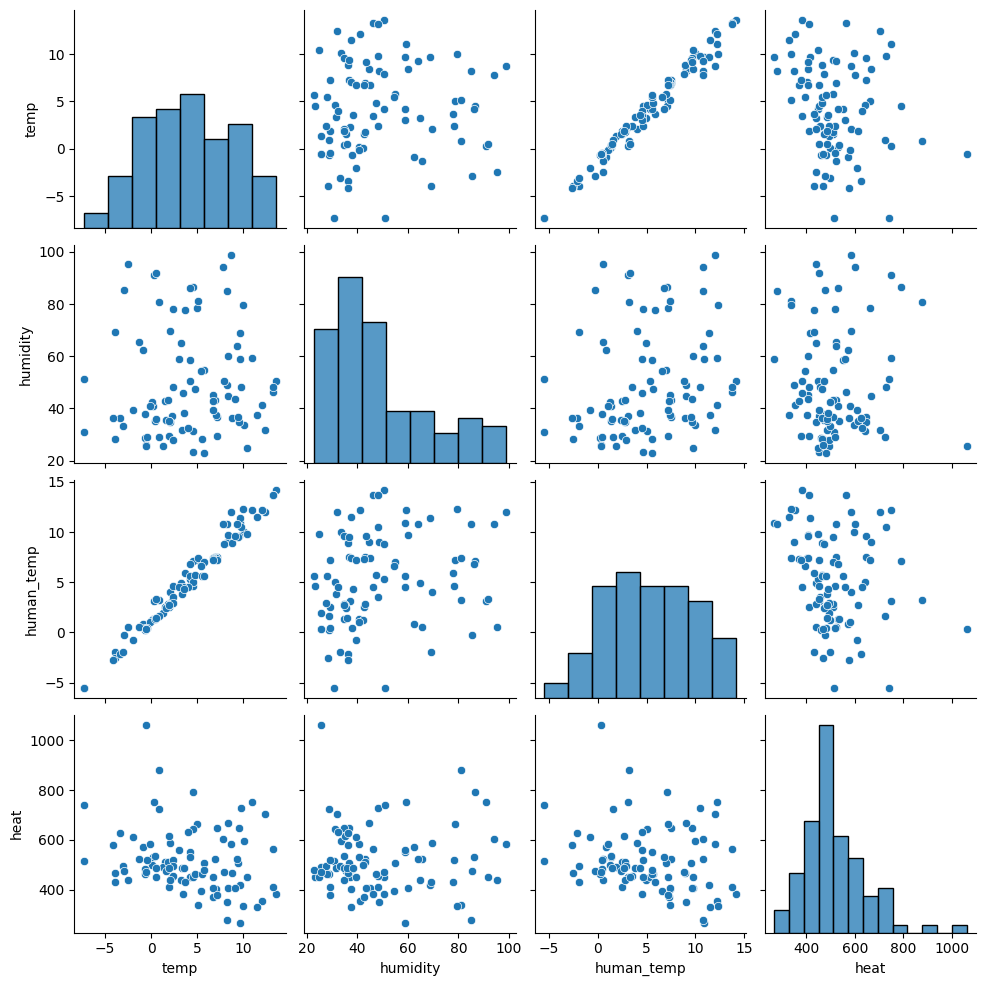

In [278]:
sns.pairplot(out11)

<AxesSubplot:>

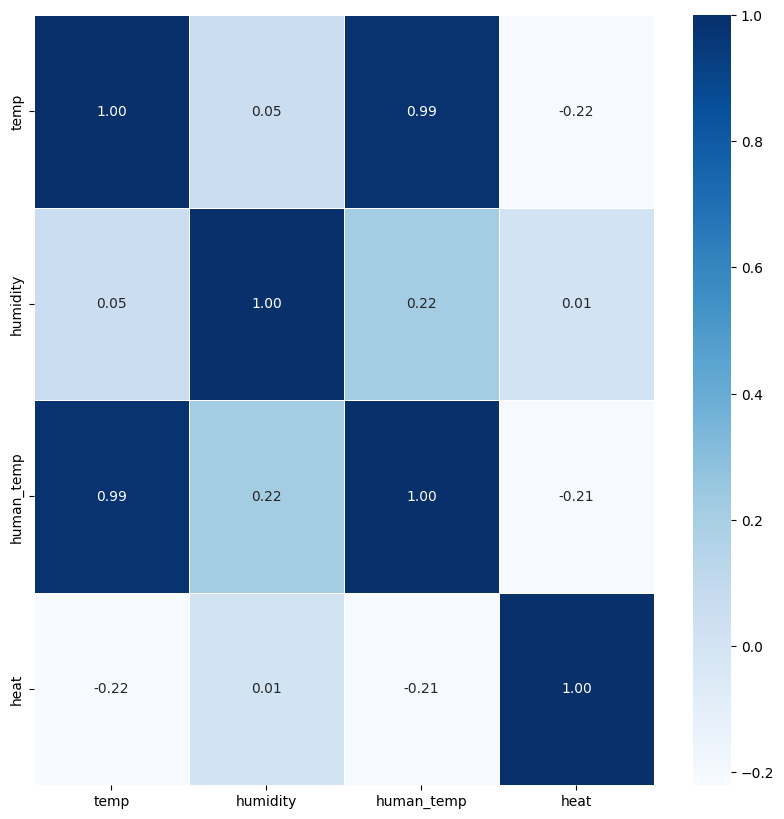

In [279]:
plt.figure(figsize=(10,10))
sns.heatmap(data = out11.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# 검증 데이터 일자별 + 외부 셋 넣기

In [280]:
submission1

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [356]:
test11 = test1.copy()
test11

,smart_farm.yy,smart_farm.mm,smart_farm.dd,smart_farm.hh,smart_farm.nn,smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2022,3,4,0,0,-4.0,2.0,76,0.0,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
1,2022,3,4,0,1,-4.1,2.0,76,0.4,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
2,2022,3,4,0,2,-4.1,1.9,76,0.0,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
3,2022,3,4,0,3,-4.1,1.9,76,0.0,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
4,2022,3,4,0,4,-4.2,1.9,76,0.0,5,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18715,2022,3,20,23,55,-3.0,6.2,61,0.4,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
18716,2022,3,20,23,56,-3.2,6.2,61,0.0,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
18717,2022,3,20,23,57,-3.2,6.1,61,0.4,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
18718,2022,3,20,23,58,-3.3,6.1,61,0.4,346,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN


In [357]:
dd2 = dd.iloc[8*30+7:8*30+24]       # ~13 /18~20
dd22 = dd2.values
dd22

array([['2022-03-04,14.6,45.8,14.9'],
       ['2022-03-05,5.3,77,7.5'],
       ['2022-03-06,6.8,20.6,6.5'],
       ['2022-03-07,8.7,30.4,8.5'],
       ['2022-03-08,12.3,44.3,12.6'],
       ['2022-03-09,14.8,34.8,14.3'],
       ['2022-03-10,15.8,23.1,14.4'],
       ['2022-03-11,18.4,47.4,18.6'],
       ['2022-03-12,19.5,53.3,20.1'],
       ['2022-03-13,12.2,100,15.7'],
       ['2022-03-14,13.2,86.1,15.9'],
       ['2022-03-15,13.3,50.7,13.9'],
       ['2022-03-16,16.8,41.2,16.6'],
       ['2022-03-17,15.1,48.1,15.5'],
       ['2022-03-18,9.6,56.6,10.7'],
       ['2022-03-19,6,80.4,8.3'],
       ['2022-03-20,8.9,51.3,9.8']], dtype=object)

In [358]:
a = dd2.values[0][0]
a.split(",")[0]

day = []
gi = []
se = []
ch = []
for i in range(len(dd2)):
    a  = dd2.values[i][0]
    s = a.split(",")
    day.append(s[0])
    gi.append(s[1])
    se.append(s[2])
    ch.append(s[3])

In [359]:
out = pd.DataFrame()   # 주어진 데이터 일자에 맞춰 구성
out['day'] = day
out['temp'] = gi
out['humidity'] = se
out['human_temp'] = ch
out

,day,temp,humidity,human_temp
0,2022-03-04,14.6,45.8,14.9
1,2022-03-05,5.3,77,7.5
2,2022-03-06,6.8,20.6,6.5
3,2022-03-07,8.7,30.4,8.5
4,2022-03-08,12.3,44.3,12.6
5,2022-03-09,14.8,34.8,14.3
6,2022-03-10,15.8,23.1,14.4
7,2022-03-11,18.4,47.4,18.6
8,2022-03-12,19.5,53.3,20.1
9,2022-03-13,12.2,100,15.7


In [360]:
out22 = out.copy()
for i in range(10,14):
    out22 = out22.drop(i, axis=0)
out22

# out22['heat'] = h
# # out22['max'] = ma1
# out22

,day,temp,humidity,human_temp
0,2022-03-04,14.6,45.8,14.9
1,2022-03-05,5.3,77,7.5
2,2022-03-06,6.8,20.6,6.5
3,2022-03-07,8.7,30.4,8.5
4,2022-03-08,12.3,44.3,12.6
5,2022-03-09,14.8,34.8,14.3
6,2022-03-10,15.8,23.1,14.4
7,2022-03-11,18.4,47.4,18.6
8,2022-03-12,19.5,53.3,20.1
9,2022-03-13,12.2,100,15.7


In [361]:
# sum
for k in tqdm(range(len(col))):
    h = []
    for i in range(int(len(test11)/1440)):
        h.append(np.mean(test11[col[k]][1440*i:1440*(i+1)]))
    out22[col[k]] = h

    
h = []
for i in range(int(len(test11)/1440)):
    h.append(np.mean(test11['smart_farm.heat_supply'][1440*i:1440*(i+1)]))
out22['heat'] = h
out22        

# ## 최대값
# ma1 = []
# for i in range(int(len(test1)/1440)):
#     ma1.append(np.max(test1['smart_farm.heat_supply'][1440*i:1440*(i+1)]))
# ma1
# len(ma1)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 477.77it/s]


,day,temp,humidity,human_temp,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,heat
0,2022-03-04,14.6,45.8,14.9,42.275000,47.625000,32.887500,39.121528,0.154167,8.626389,0.953472,0.527778,28.453819,18.755903,NaN
1,2022-03-05,5.3,77,7.5,42.430556,47.530556,33.873611,39.481944,0.233333,7.593750,0.920139,0.403472,28.456806,18.757986,NaN
2,2022-03-06,6.8,20.6,6.5,42.509028,48.284722,33.713889,39.187500,0.259028,13.611806,0.975000,0.467361,28.460278,18.761250,NaN
3,2022-03-07,8.7,30.4,8.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.969444,28.345000,18.765625,NaN
4,2022-03-08,12.3,44.3,12.6,31.134722,36.717361,25.850694,27.529861,0.206250,12.102778,0.963889,0.557639,28.467361,18.768542,NaN
5,2022-03-09,14.8,34.8,14.3,43.306944,48.720139,35.645139,39.792361,0.265972,21.179861,0.950000,0.413194,28.470347,18.772569,NaN
6,2022-03-10,15.8,23.1,14.4,43.070833,48.928472,35.561806,40.340278,0.228472,12.465972,0.882639,0.367361,28.473681,18.775000,NaN
7,2022-03-11,18.4,47.4,18.6,43.540972,49.043750,36.911111,40.922917,0.126389,8.931250,0.921528,0.439236,28.476806,18.963889,NaN
8,2022-03-12,19.5,53.3,20.1,43.606944,47.863194,45.103472,43.961806,0.274306,21.372917,0.924306,0.224306,28.480486,18.781944,NaN
9,2022-03-13,12.2,100,15.7,40.878472,46.225000,33.113889,43.567361,0.000000,0.000000,0.789583,0.396181,28.483611,18.964583,NaN


In [362]:
out22['temp'] = out22['temp'].astype('float')
out22['humidity'] = out22['humidity'].astype('float')
out22['human_temp'] = out22['human_temp'].astype('float')
out22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 16
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   day                                         13 non-null     object 
 1   temp                                        13 non-null     float64
 2   humidity                                    13 non-null     float64
 3   human_temp                                  13 non-null     float64
 4   smart_farm.shield_light_h                   13 non-null     float64
 5   smart_farm.shield_tmperature_h              13 non-null     float64
 6   smart_farm.shield_energy_h                  13 non-null     float64
 7   smart_farm.shield_energy_v                  13 non-null     float64
 8   smart_farm.exhaust_fan                      13 non-null     float64
 9   smart_farm.ceiling                          13 non-null     float64
 10  smart_farm.float

In [370]:
out11.columns

Index(['day', 'temp', 'humidity', 'human_temp', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'heat'],
      dtype='object')

# Model1

In [380]:
max_depth = 5
n_estimators = 5000             # 400  #1000
lr = 0.01             # 0.017
num_leaves = 100
early_stopping_rounds = 300      # 100
verbose = True                  # True

In [381]:
X = out11.drop(['day', 'temp', 'humidity', 'human_temp','heat'], axis=1)
y = out11[['heat']].values

X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.3)

X_test1 = out22.drop(['day', 'temp', 'humidity', 'human_temp','heat'], axis=1)

In [382]:
# X = train11.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'], axis=1)
# y = train11[['smart_farm.heat_supply']].values

# X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.3)

# X_test1 = test11.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'],axis=1)

In [383]:
lgbm_reg1 = LGBMRegressor(objective= "regression",
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)
    
lgbm_reg1.fit(X_train1, y_train1,
          eval_set=[(X_val1, y_val1)],
          eval_metric=["mse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 

[1]	valid_0's l2: 0.00596951
[2]	valid_0's l2: 0.00599074
[3]	valid_0's l2: 0.00601194
[4]	valid_0's l2: 0.0060331
[5]	valid_0's l2: 0.00605422
[6]	valid_0's l2: 0.0060753
[7]	valid_0's l2: 0.00607538
[8]	valid_0's l2: 0.00609635
[9]	valid_0's l2: 0.00609662
[10]	valid_0's l2: 0.00611746
[11]	valid_0's l2: 0.00610704
[12]	valid_0's l2: 0.00612777
[13]	valid_0's l2: 0.00611761
[14]	valid_0's l2: 0.00610767
[15]	valid_0's l2: 0.00612823
[16]	valid_0's l2: 0.00611854
[17]	valid_0's l2: 0.00613898
[18]	valid_0's l2: 0.00612953
[19]	valid_0's l2: 0.00614985
[20]	valid_0's l2: 0.00615068
[21]	valid_0's l2: 0.00614156
[22]	valid_0's l2: 0.00616168
[23]	valid_0's l2: 0.00615278
[24]	valid_0's l2: 0.00617278
[25]	valid_0's l2: 0.0061641
[26]	valid_0's l2: 0.00618397
[27]	valid_0's l2: 0.00617551
[28]	valid_0's l2: 0.00619525
[29]	valid_0's l2: 0.006187
[30]	valid_0's l2: 0.00618824
[31]	valid_0's l2: 0.00620776
[32]	valid_0's l2: 0.0061998
[33]	valid_0's l2: 0.00619201
[34]	valid_0's l2: 0.0062

C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=5000,
              num_leaves=100, objective='regression')

In [400]:
pred_ = lgbm_reg1.predict(X_test1)
pred_

array([0.364908  , 0.36459357, 0.364908  , 0.36533631, 0.36533631,
       0.364908  , 0.36459357, 0.36459357, 0.36459357, 0.36459357,
       0.364908  , 0.364908  , 0.36459357])

In [399]:
pred_*100

array([36.49079952, 36.4593567 , 36.49079952, 36.53363099, 36.53363099,
       36.49079952, 36.4593567 , 36.4593567 , 36.4593567 , 36.4593567 ,
       36.49079952, 36.49079952, 36.4593567 ])

In [385]:
# # 평균
# pred1 = []
# for i in range(int(len(pred_)/1440)):
#     pred1.append(np.sum(pred_[1440*i:1440*(i+1)]))
# pred1
# len(pred1)

# ## 최대값
# pred2 = []
# for i in range(int(len(pred_)/1440)):
#     pred2.append(np.max(pred_[1440*i:1440*(i+1)]))
# pred2
# len(pred2)

0

In [395]:
int(39/3)

13

In [392]:
# pred1 = []
# for i in range(int(len(pred_)/3)):
#     pred1.append(np.sum(pred_[1440*i:1440*(i+1)]))
# pred1
# len(pred1)

4

In [412]:
submission1['heat_supply_day1'] = pred_*1000
submission1 

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,364.907995,354.792247
1,2022,3,5,364.593567,354.792247
2,2022,3,6,364.907995,354.792247
3,2022,3,7,365.336310,357.651886
4,2022,3,8,365.336310,357.651886
5,2022,3,9,364.907995,354.792247
6,2022,3,10,364.593567,354.792247
7,2022,3,11,364.593567,354.792247
8,2022,3,12,364.593567,354.792247
9,2022,3,13,364.593567,354.792247


# Model2

In [363]:
max_depth = 5
n_estimators = 5000             # 400  #1000
lr = 0.01             # 0.017
num_leaves = 100
early_stopping_rounds = 300      # 100
verbose = True                  # True

In [364]:
X = out11.drop(['day','heat'], axis=1)
y = out11[['heat']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

X_test = out22.drop(['day','heat'], axis=1)

In [365]:
# # 결측치 제거한 train1,test1에 대해서
# X = train1[['smart_farm.mm','smart_farm.hh','smart_farm.nn']]
# y = train1[['smart_farm.heat_supply']].values

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# X_test = test1[['smart_farm.mm','smart_farm.hh','smart_farm.nn']]

In [366]:
# # 결측치 제거한 train1,test1에 대해서
# X = train1.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'], axis=1)
# y = train1[['smart_farm.heat_supply']].values

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# X_test = test1.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'],axis=1)

In [367]:
# X_train = train.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'], axis=1)
# X_val = val.drop(['smart_farm.yy', 'smart_farm.mm', 'smart_farm.dd', 'smart_farm.hh', 'smart_farm.nn', 'smart_farm.heat_supply'],axis=1)

# y_train = train[['smart_farm.heat_supply']].values
# y_val = val[['smart_farm.heat_supply']].values

lgbm_reg = LGBMRegressor(objective= "regression",
                     max_depth= max_depth,
                     n_estimators= n_estimators,
                     learning_rate= lr,
                     num_leaves = num_leaves)
    
lgbm_reg.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric=["mse"],
          early_stopping_rounds=early_stopping_rounds,
          verbose=verbose) 


[1]	valid_0's l2: 0.00949499
[2]	valid_0's l2: 0.00949395
[3]	valid_0's l2: 0.00949309
[4]	valid_0's l2: 0.00949242
[5]	valid_0's l2: 0.00950127
[6]	valid_0's l2: 0.00951015
[7]	valid_0's l2: 0.00950963
[8]	valid_0's l2: 0.00951856
[9]	valid_0's l2: 0.00951819
[10]	valid_0's l2: 0.00952716
[11]	valid_0's l2: 0.00953613
[12]	valid_0's l2: 0.0095359
[13]	valid_0's l2: 0.00954491
[14]	valid_0's l2: 0.00954482
[15]	valid_0's l2: 0.00955385
[16]	valid_0's l2: 0.00955389
[17]	valid_0's l2: 0.00956294
[18]	valid_0's l2: 0.009572
[19]	valid_0's l2: 0.00957214
[20]	valid_0's l2: 0.00958864
[21]	valid_0's l2: 0.00958881
[22]	valid_0's l2: 0.00960532
[23]	valid_0's l2: 0.00960554
[24]	valid_0's l2: 0.00961461
[25]	valid_0's l2: 0.00963115
[26]	valid_0's l2: 0.00963137
[27]	valid_0's l2: 0.00964393
[28]	valid_0's l2: 0.00966051
[29]	valid_0's l2: 0.00966069
[30]	valid_0's l2: 0.00967727
[31]	valid_0's l2: 0.00967749
[32]	valid_0's l2: 0.00969002
[33]	valid_0's l2: 0.00969909
[34]	valid_0's l2: 0.0

C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\younjeongOh\anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=5000,
              num_leaves=100, objective='regression')

In [368]:
pred = lgbm_reg.predict(X_test)
pred                        

array([0.35479225, 0.35479225, 0.35479225, 0.35765189, 0.35765189,
       0.35479225, 0.35479225, 0.35479225, 0.35479225, 0.35479225,
       0.35479225, 0.35479225, 0.35479225])

In [411]:
# # pred = lgbm_reg.predict(X_test)
# submission=pd.read_csv('1-1_검증데이터셋.csv', encoding='utf-8')
# submission1=submission.copy()
submission1['heat_supply_day2'] = pred*1000
submission1 
# submission1.to_csv("farm_lgbm.csv", index = False)            # 6위

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,3649.079952,354.792247
1,2022,3,5,3645.935670,354.792247
2,2022,3,6,3649.079952,354.792247
3,2022,3,7,3653.363099,357.651886
4,2022,3,8,3653.363099,357.651886
5,2022,3,9,3649.079952,354.792247
6,2022,3,10,3645.935670,354.792247
7,2022,3,11,3645.935670,354.792247
8,2022,3,12,3645.935670,354.792247
9,2022,3,13,3645.935670,354.792247


In [413]:
submission1.to_csv('human_temp.csv', index=False)

In [ ]:
## day1도 일자별로 컬럼 모두 형태 바꿔 해야할지